# Etapa 5: Modelagem - Análise de Crédito

---

## Objetivo
Desenvolver modelos de Machine Learning para prever rejeição de crédito, comparando:
- **Modelo Baseline:** Regressão Logística
- **Modelo Avançado:** LGBM com desbalanceamento

In [1]:
!pip install lightgbm xgboost imbalanced-learn shap -q

## 2. Importação de Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score,
    recall_score,
    precision_score
)

import lightgbm as lgb
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import shap

## 3. Upload dos Arquivos no Colab

- `X_train.csv`
- `X_test.csv`
- `y_train.csv`
- `y_test.csv`
- `scaler.pkl`

## 4. Carregamento dos Dados

In [5]:
# Carregar dados de treino e teste
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').squeeze()
y_test = pd.read_csv('y_test.csv').squeeze()

# Carregar scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print("Dimensões dos dados:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")

print("\nDistribuição da variável alvo (y_train):")
print(y_train.value_counts())
print(f"\n   Proporção Rejeitado: {y_train.value_counts(normalize=True)[1]:.2%}")
print(f"   Proporção Aprovado: {y_train.value_counts(normalize=True)[0]:.2%}")

# Calcular scale_pos_weight
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos
print(f"\ncalculado: {scale_pos_weight:.2f}")

Dimensões dos dados:
   X_train: (3600, 17)
   X_test: (900, 17)
   y_train: (3600,)
   y_test: (900,)

Distribuição da variável alvo (y_train):
loan_status_encoded
1    2376
0    1224
Name: count, dtype: int64

   Proporção Rejeitado: 66.00%
   Proporção Aprovado: 34.00%

calculado: 0.52


## 5. Modelo Baseline: Regressão Logística

Demonstração de que um modelo linear simples não consegue capturar a complexidade dos dados, especialmente com desbalanceamento de classes.

In [6]:
# Treinar Regressão Logística
print("Treinando Regressão Logística")

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predições
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

Treinando Regressão Logística


AVALIAÇÃO DO MODELO (REGRESSÃO LOGÍSTICA)

Métricas Principais:
   AUC Score: 0.8594
   Recall (Rejeitado): 0.9074
   Precision (Rejeitado): 0.8009
   F1-Score: 0.8508
              precision    recall  f1-score   support

    Aprovado       0.76      0.56      0.65       306
   Rejeitado       0.80      0.91      0.85       594

    accuracy                           0.79       900
   macro avg       0.78      0.73      0.75       900
weighted avg       0.79      0.79      0.78       900



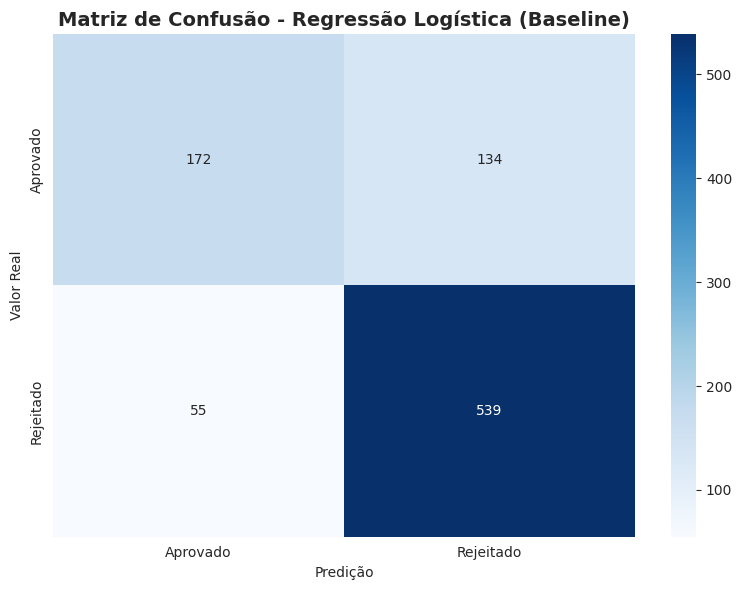


Como esperado, o modelo baseline apresenta desempenho ruim,
   especialmente no Recall da classe 'Rejeitado'.


In [7]:
# Avaliação do Baseline
print("AVALIAÇÃO DO MODELO (REGRESSÃO LOGÍSTICA)")

# Métricas principais
auc_lr = roc_auc_score(y_test, y_proba_lr)
recall_lr = recall_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"\nMétricas Principais:")
print(f"   AUC Score: {auc_lr:.4f}")
print(f"   Recall (Rejeitado): {recall_lr:.4f}")
print(f"   Precision (Rejeitado): {precision_lr:.4f}")
print(f"   F1-Score: {f1_lr:.4f}")
print(classification_report(y_test, y_pred_lr, target_names=['Aprovado', 'Rejeitado']))

# Matriz de Confusão
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Aprovado', 'Rejeitado'],
            yticklabels=['Aprovado', 'Rejeitado'])
plt.title('Matriz de Confusão - Regressão Logística (Baseline)', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.tight_layout()
plt.savefig('confusion_matrix_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComo esperado, o modelo baseline apresenta desempenho ruim,")
print("   especialmente no Recall da classe 'Rejeitado'.")

## 6. Modelo Avançado: LGBM com Tratamento de Desbalanceamento
- Usar LGBM (rápido e eficiente para dados tabulares)
- Aplicar scale_pos_weight para tratar desbalanceamento

In [9]:
# Treinar LGBM inicial
lgbm_model = LGBMClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    verbose=-1
)

lgbm_model.fit(X_train, y_train)

# Predições
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

AVALIAÇÃO DO MODELO LIGHTGBM (SEM OTIMIZAÇÃO)

Métricas Principais:
   Score: 0.9473
   Recall (Rejeitado): 0.8973
   Precision (Rejeitado): 0.9206
   F1: 0.9088
              precision    recall  f1-score   support

    Aprovado       0.81      0.85      0.83       306
   Rejeitado       0.92      0.90      0.91       594

    accuracy                           0.88       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.88      0.88      0.88       900



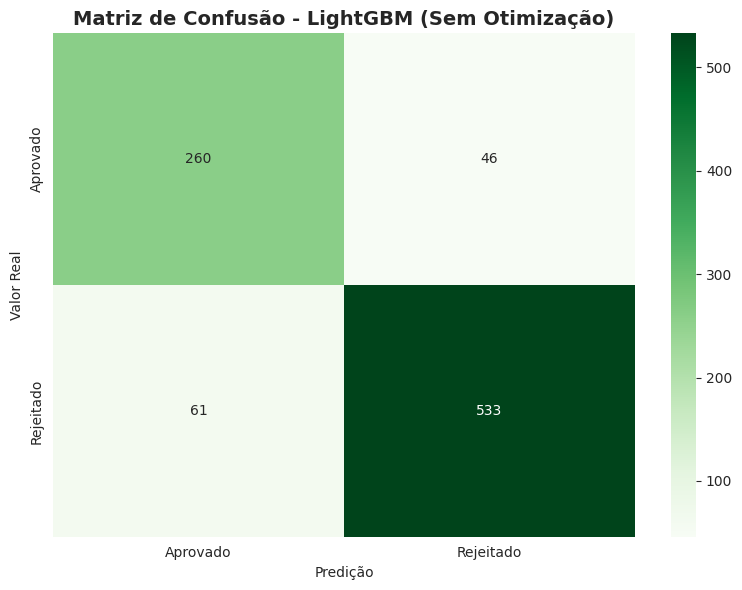


Melhoria significativa em relação ao modelo base


In [10]:
print("AVALIAÇÃO DO MODELO LIGHTGBM (SEM OTIMIZAÇÃO)")

# Métricas principais
auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)

print(f"\nMétricas Principais:")
print(f"   Score: {auc_lgbm:.4f}")
print(f"   Recall (Rejeitado): {recall_lgbm:.4f}")
print(f"   Precision (Rejeitado): {precision_lgbm:.4f}")
print(f"   F1: {f1_lgbm:.4f}")
print(classification_report(y_test, y_pred_lgbm, target_names=['Aprovado', 'Rejeitado']))

# Matriz de Confusão
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Aprovado', 'Rejeitado'],
            yticklabels=['Aprovado', 'Rejeitado'])
plt.title('Matriz de Confusão - LightGBM (Sem Otimização)', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.tight_layout()
plt.savefig('confusion_matrix_lgbm_initial.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMelhoria significativa em relação ao modelo base")

## 7. Otimização de Hiperparâmetros

In [11]:
# Grid de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 0.9, 1.0]
}

lgbm_base = LGBMClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    verbose=-1
)

grid_search = GridSearchCV(
    estimator=lgbm_base,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
print(f"\nMelhores hiperparâmetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\nMelhor Score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits

Melhores hiperparâmetros encontrados:
   learning_rate: 0.01
   max_depth: 5
   min_child_samples: 50
   n_estimators: 300
   subsample: 0.8

Melhor Score: 0.9549



Métricas Principais:
Score: 0.9509
Recall (Rejeitado): 0.8822
Precision (Rejeitado): 0.9209
F1: 0.9011
              precision    recall  f1-score   support

    Aprovado       0.79      0.85      0.82       306
   Rejeitado       0.92      0.88      0.90       594

    accuracy                           0.87       900
   macro avg       0.85      0.87      0.86       900
weighted avg       0.88      0.87      0.87       900



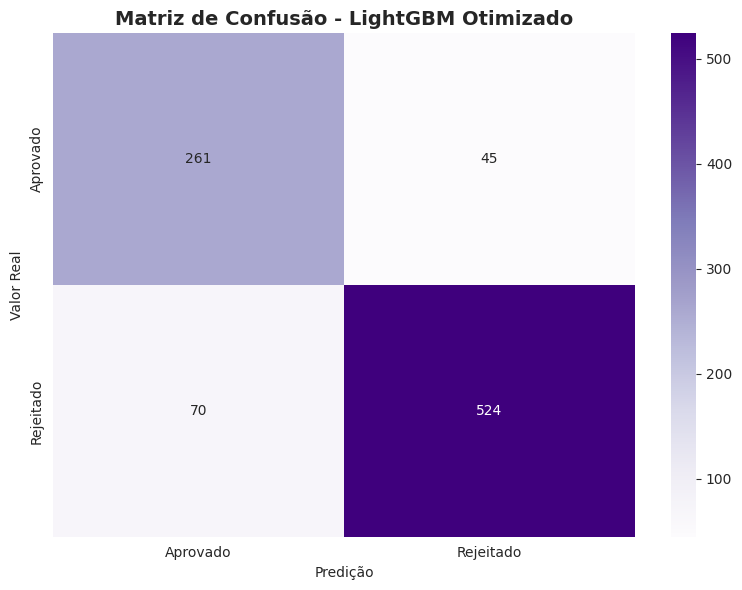

In [12]:
# Modelo otimizado
best_lgbm_model = grid_search.best_estimator_

# Predições com modelo otimizado
y_pred_best = best_lgbm_model.predict(X_test)
y_proba_best = best_lgbm_model.predict_proba(X_test)[:, 1]

# Avaliação do modelo otimizado
# Métricas principais
auc_best = roc_auc_score(y_test, y_proba_best)
recall_best = recall_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f"\nMétricas Principais:")
print(f"Score: {auc_best:.4f}")
print(f"Recall (Rejeitado): {recall_best:.4f}")
print(f"Precision (Rejeitado): {precision_best:.4f}")
print(f"F1: {f1_best:.4f}")
print(classification_report(y_test, y_pred_best, target_names=['Aprovado', 'Rejeitado']))

# Matriz de Confusão
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Aprovado', 'Rejeitado'],
            yticklabels=['Aprovado', 'Rejeitado'])
plt.title('Matriz de Confusão - LightGBM Otimizado', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.tight_layout()
plt.savefig('confusion_matrix_lgbm_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Comparação de Modelos

COMPARAÇÃO DE MODELOS
                        Modelo  AUC Score  Recall (Rejeitado)  Precision (Rejeitado)  F1-Score
Regressão Logística (Baseline)   0.859406            0.907407               0.800892  0.850829
              LightGBM Inicial   0.947272            0.897306               0.920553  0.908781
            LightGBM Otimizado   0.950936            0.882155               0.920914  0.901118


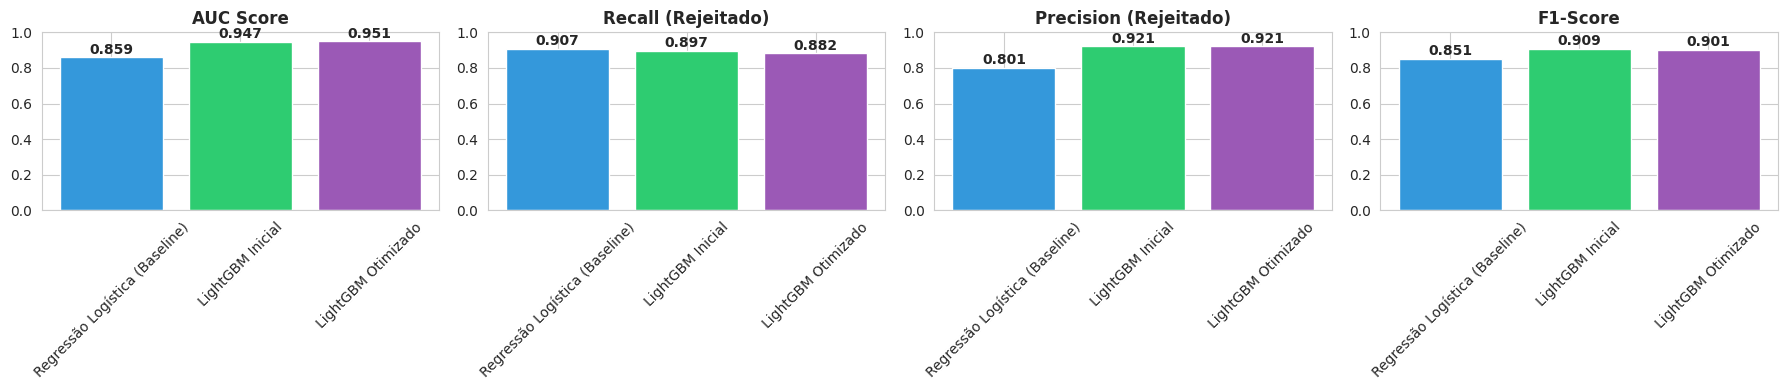

In [13]:
# Tabela comparativa
comparison_df = pd.DataFrame({
    'Modelo': ['Regressão Logística (Baseline)', 'LightGBM Inicial', 'LightGBM Otimizado'],
    'AUC Score': [auc_lr, auc_lgbm, auc_best],
    'Recall (Rejeitado)': [recall_lr, recall_lgbm, recall_best],
    'Precision (Rejeitado)': [precision_lr, precision_lgbm, precision_best],
    'F1-Score': [f1_lr, f1_lgbm, f1_best]
})

print("COMPARAÇÃO DE MODELOS")
print(comparison_df.to_string(index=False))

# Visualização comparativa
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
metrics = ['AUC Score', 'Recall (Rejeitado)', 'Precision (Rejeitado)', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#9b59b6']

for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df['Modelo'], comparison_df[metric], color=colors)
    axes[i].set_title(metric, fontweight='bold')
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)

    # Adicionar valores nas barras
    for j, v in enumerate(comparison_df[metric]):
        axes[i].text(j, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Curva ROC

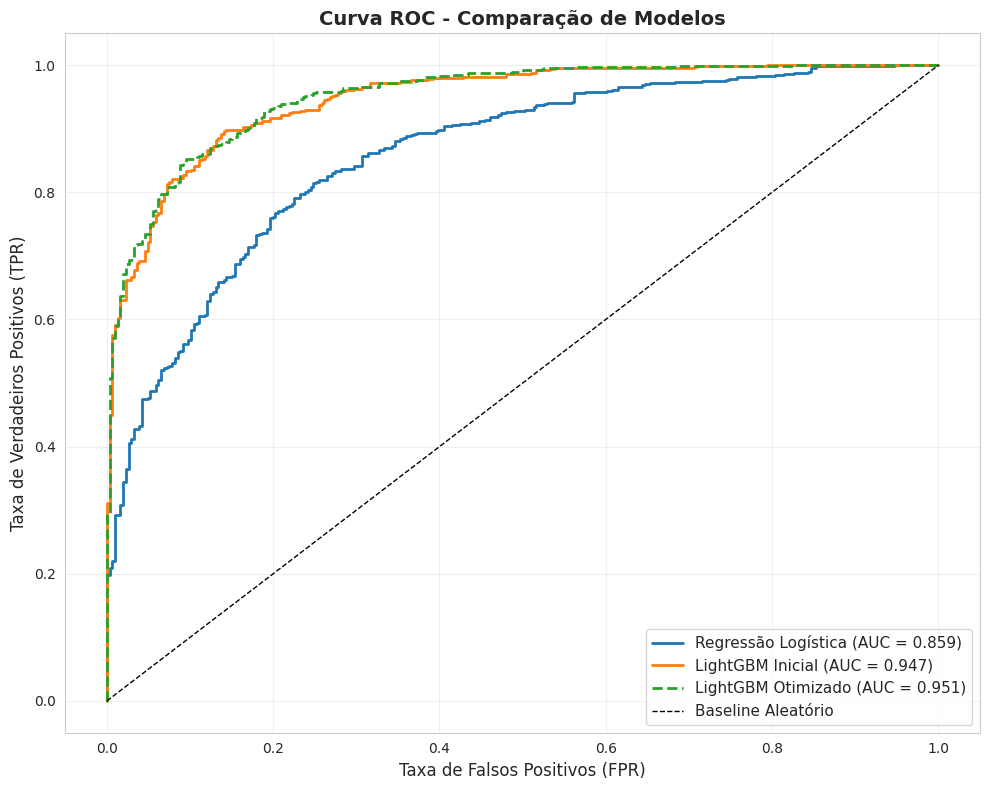

In [14]:
# Calcular curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)

# Plotar curvas ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {auc_lr:.3f})', linewidth=2)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM Inicial (AUC = {auc_lgbm:.3f})', linewidth=2)
plt.plot(fpr_best, tpr_best, label=f'LightGBM Otimizado (AUC = {auc_best:.3f})', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline Aleatório', linewidth=1)

plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.title('Curva ROC - Comparação de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Interpretabilidade com SHAP
- Identificar features mais importantes
- Explicar predições individuais
- Validar que o modelo aprendeu regras financeiras válidas

In [15]:
# Criar SHAP

# Usar uma amostra para acelerar o cálculo
X_sample = X_test.sample(n=min(500, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(best_lgbm_model)
shap_values = explainer.shap_values(X_sample)

Resumo do SHAP 



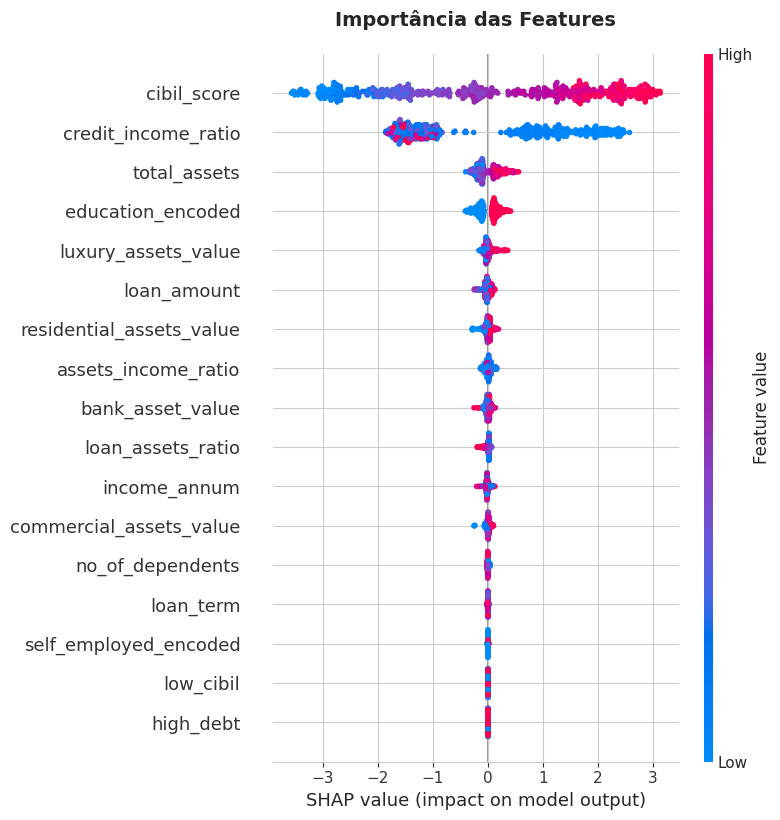

In [17]:
print("Resumo do SHAP \n")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('Importância das Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

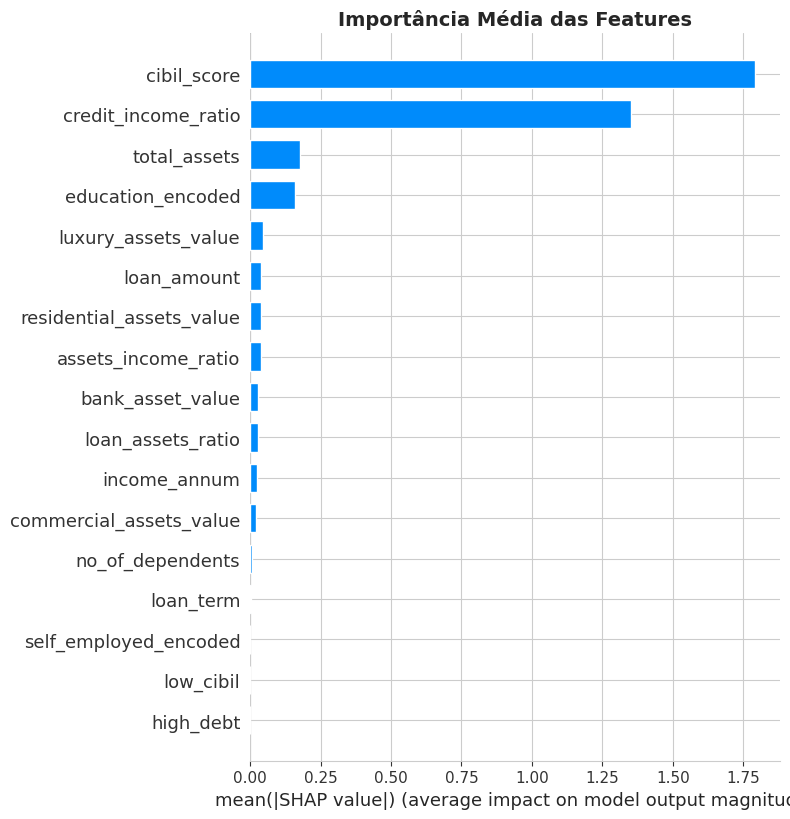

In [19]:
# Importância média das features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
plt.title('Importância Média das Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

TOP 10 FEATURES MAIS IMPORTANTES
                 Feature  Importance
             cibil_score        2167
     credit_income_ratio        1266
            total_assets         805
       education_encoded         491
     luxury_assets_value         418
residential_assets_value         417
       loan_assets_ratio         354
 commercial_assets_value         288
        bank_asset_value         277
             loan_amount         274


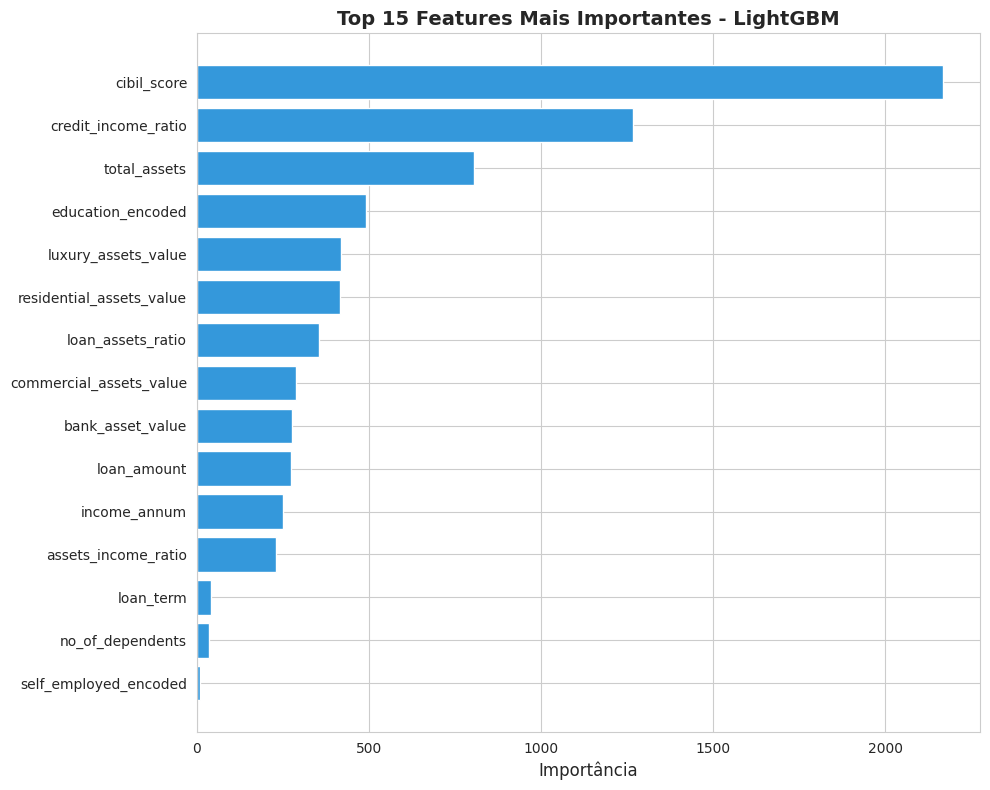

In [20]:
# Feature Importance do LGBM
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_lgbm_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("TOP 10 FEATURES MAIS IMPORTANTES")
print(feature_importance.head(10).to_string(index=False))

# Visualização
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], color='#3498db')
plt.xlabel('Importância', fontsize=12)
plt.title('Top 15 Features Mais Importantes - LightGBM', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Salvar Modelos e Resultados

In [21]:
# Salvar modelo otimizado
with open('lgbm_model_optimized.pkl', 'wb') as f:
    pickle.dump(best_lgbm_model, f)

# Salvar modelo baseline
with open('logistic_regression_baseline.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Salvar tabela de comparação
comparison_df.to_csv('model_comparison.csv', index=False)

# Salvar feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

In [22]:
from google.colab import files

files_to_download = [
    'lgbm_model_optimized.pkl',
    'logistic_regression_baseline.pkl',
    'model_comparison.csv',
    'feature_importance.csv',
    'confusion_matrix_baseline.png',
    'confusion_matrix_lgbm_initial.png',
    'confusion_matrix_lgbm_optimized.png',
    'model_comparison.png',
    'roc_curve_comparison.png',
    'shap_summary_plot.png',
    'shap_bar_plot.png',
    'feature_importance.png'
]

for file in files_to_download:
    try:
        files.download(file)
        print(f"{file}")
    except:
        print(f"{file} não encontrado")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

lgbm_model_optimized.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

logistic_regression_baseline.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

model_comparison.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

feature_importance.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

confusion_matrix_baseline.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

confusion_matrix_lgbm_initial.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

confusion_matrix_lgbm_optimized.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

model_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

roc_curve_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

shap_summary_plot.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

shap_bar_plot.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

feature_importance.png
